# Подготовка к работе

 Прежде чем работать в Google colab, зайдите в Edit -> Notebook settings и установите в Hardware settings параметр GPU.  
Для работы в Google Colab загрузжаем в папку content архив human_seg.zip, который представляет собой копию папок из human_segmentation. Архив можно найти в корне Human_segmentation в [моем Github](https://github.com/Sashmark97/InternshipTestTask/tree/master/human_segmentation). Разархивируем скачанный архив.

In [0]:
!unzip -q '/content/human_seg.zip'

Установим библиотеки Segmentation models и Albumentations:

In [3]:
!pip install -q segmentation_models
!pip install -q albumentations

     |████████████████████████████████| 51kB 2.4MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 634kB 3.5MB/s 


In [4]:
import os
#os.chdir("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import cv2, keras
import segmentation_models as sm
from segmentation_models import unet

from glob import glob

from lib import *

#%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [5]:
add_path = os.getcwd()
print(add_path)

/content


# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные маски для картинок из `valid` в формате `pred_valid_template.csv`;
- html страницу с предсказанием модели для всех картинок из `test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез и т.п.

Примеры приведены ниже.

---

# Данные, метрики и доступные функции

Посмотрим на данные:

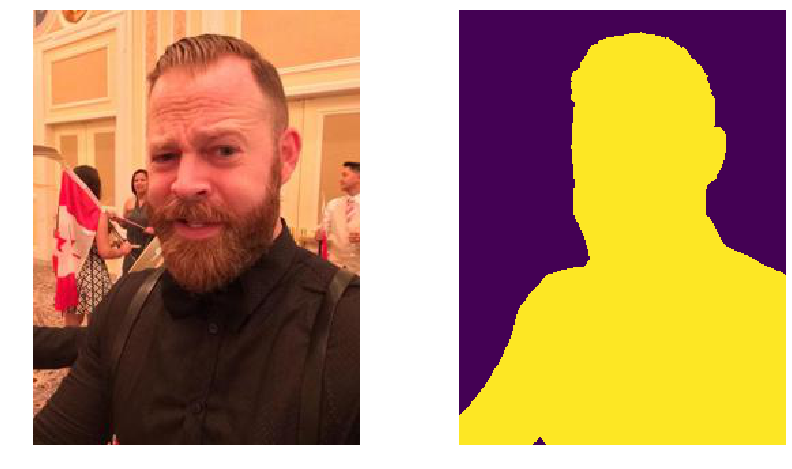

In [6]:
path = add_path + "/data/train"
images = os.listdir(path)
ind = np.random.choice(images).split(".")[0]

img = np.array(Image.open(f"{path}/{ind}.jpg"))
mask = np.array(Image.open(f"{path}_mask/{ind}.png"))
show_img_with_mask(img, mask)

Пример подсчета метрики:

In [7]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask)

0.5407708743255145

Можно для последовательности масок вычислить среднее значение метрики:

In [8]:
random_masks_1 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
random_masks_2 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
get_dice(random_masks_1, random_masks_2)

0.500363602916789

Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [9]:
rle_mask = encode_rle(mask)
rle_mask

'3974 1 4206 12 4442 23 4675 34 4909 43 4953 2 5147 49 5384 53 5623 56 5863 57 6100 61 6338 65 6577 67 6645 1 6817 70 7056 72 7296 73 7535 74 7775 75 8014 77 8253 78 8493 79 8732 82 8971 84 9210 86 9450 86 9690 88 9930 89 10170 89 10408 92 10647 94 10885 96 11124 98 11364 98 11604 100 11843 100 12083 100 12323 100 12564 100 12803 101 13043 102 13283 102 13523 102 13763 102 14004 102 14244 103 14484 102 14724 102 14963 104 15203 105 15443 105 15683 106 15924 105 16165 104 16406 103 16646 103 16886 103 17125 104 17365 104 17605 104 17845 104 18085 104 18325 104 18565 104 18805 104 19045 104 19285 104 19525 104 19765 104 20004 105 20244 105 20484 104 20724 109 20964 110 21204 111 21444 112 21684 112 21924 113 22164 113 22404 113 22644 113 22884 113 23124 113 23364 113 23604 113 23843 114 24083 114 24323 114 24564 113 24804 113 25044 113 25284 112 25524 112 25764 112 26004 112 26244 112 26484 111 26724 111 26964 111 27205 109 27445 109 27685 109 27925 108 28165 108 28405 107 28645 107 2888

Теперь восстановим маску:

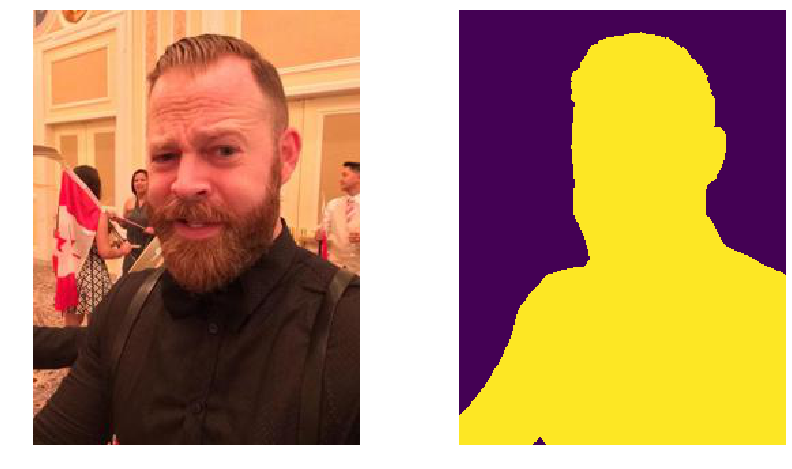

In [10]:
decoded_mask = decode_rle(rle_mask)
show_img_with_mask(img, decoded_mask)

In [77]:
mask.shape

(320, 240)

---

# Результаты

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [11]:
pred = pd.read_csv("data/pred_valid_template.csv")
pred.head()

,id,rle_mask
0,1315,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
1,1316,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
2,1317,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
3,1318,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
4,1319,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...


Для данных из `test` требуется создать html страницу + картинки для нее.  
Это можно сделать с помощью функции `get_html`, как показано ниже.

In [0]:
paths_to_imgs = sorted(glob("data/valid/*"))
#print(paths_to_imgs)
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("data/valid_mask/*"))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.

************************

# Решение задачи


Перед тем как приступить к задаче проведем анализ статей и учебных материалов по смежным темам, а именно:  
* [Статья](https://arxiv.org/pdf/1505.04597.pdf) по Unet
* [Статья](https://arxiv.org/pdf/1612.03144.pdf) по Feature Pyramid Network 
* [Видео лекция](https://www.youtube.com/watch?v=OWK8VlgJM4I) Deep Learning School по сегментации
* [Статья](https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac) по библиотке albumentations 

В результате было решено придерживаться  следующего подхода:  
1. Использовать pre-trained модель, ввиду ограниченных вычислительных ресурсов
2. Для упрощения работы с сегментационными моделями(подбор backbone для них) установить библиотеку [Segmentation Models](https://github.com/qubvel/segmentation_models)
3. Для упрощения работы по аугментации данных использовать библиотеку [Albumentations](https://github.com/albu/albumentations)
4. Для предложенной задачи попробовать две архитектуры сетей: FPN и Unet с различными backbone

# Препроцессинг и анализ данных

Посмотрим на размеры датасетов, убедимся, что количество изображений соответствует количеству масок. Также посмотрим на размеры изображений и масок:

In [13]:
train_path = "data/train"
val_path = "data/valid"
test_path = "data/test"
train_files, train_masks, valid_files, valid_masks, test_files = analyze_dataset(train_path, val_path, test_path)

Size of train datasest: 1315 images and 1315 masks
Size of validation datasest: 145 images and 145 masks
Size of test datasest: 100 images
Image size is: 320x240x3
Mask size is:  320x240x1
Each pixel in image belongs to [0, 255]
Each pixel in mask belongs to  [0, 255]


Видно, что датасет для тренировки не слишком большой. Стоит воспользоваться аугментацией данных.  


Создадим трейновый датафрейм с масками и номерами изображений. В дальнейшем он потребуется для генератора. Предварительно отсортируем входные данные:

In [0]:
train_masks.sort()
train_files.sort()
valid_masks.sort()
valid_files.sort()

In [0]:
train_df = pd.DataFrame(columns = ['img' , 'mask_rle'])
for i in range(len(train_files)):
    index = train_files[i].split("/")[2].split('.')[0]
    train_df.loc[i] = [index, encode_rle(np.array(Image.open(f"{train_path}_mask/{index}.png")))]


In [0]:
val_df = pd.DataFrame(columns = ['img' , 'mask_rle'])
for e in valid_files:
    index = e.split("/")[2].split('.')[0]
    val_df.loc[index] = [index, encode_rle(np.array(Image.open(f"{val_path}_mask/{index}.png")))]

Убедимся что датафрейм составлен правильно:

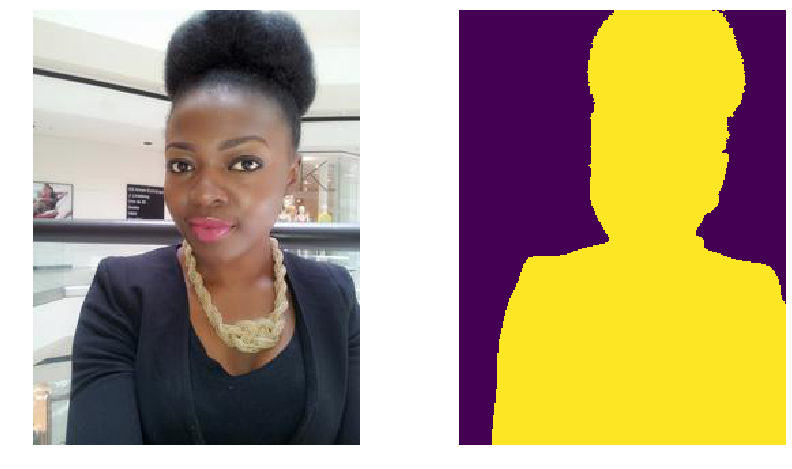

In [17]:
import random
ind = random.randint(0,1000)
decoded_mask = decode_rle(train_df.loc[ind][1])
show_img_with_mask(np.array(Image.open(f"{train_path}/{train_df.loc[ind][0]}.jpg")), decoded_mask)

Получим заранее подготовленные композиции преобразований для аугментации данных. Их три штуки:
* Со слабыми преобразованиями
* С сильными геометрическими искажениями
* Специальный набор для PSPNet  

Для PSPNet сделан отдельный набор, т.к. входные данные данной архитектуры должны быть кратны 48(при стандартном коэффициенте downsampling), в то время как вход для Unet, FPN и Linknet равен 256х256. К сожалению, PSPNet не удалось быстро отладить, поэтому набор аугментаций для него не применялся. Однако я решил оставить его в качестве заготовки на будущее, если появится время для отладки.

In [0]:
AUGMENTATIONS_TRAIN_LIGHT, AUGMENTATIONS_TRAIN, AUGMENTATIONS_TRAIN_PSPNet = get_augs()

Стоит отметить, что написанные мной генераторы батчей для Keras являются удобным инструментом для:  
1. Проверки работы аугментаций(для этого необходимо вызвать генератор с аугментациями и, внося изменения в набор аугментаций, смотреть за поведением картинки)
2. Быстрого создания небольшого набора картинок для проверки качества сегментации людей сразу после тренировки сети.  

P.S.: Отмечу, что генератор с аугментациями имеет удвоенный размер батча. Связано это с тем, что я создаю аугментированную копию каждого изображения батча и добавляю её в него же.

In [0]:
for x, y in keras_generator_with_augs(train_df, 16, train_path, AUGMENTATIONS_TRAIN_LIGHT):
    break

In [0]:
for x_val, y_val in keras_generator(val_df, 16, val_path):
    break

Проверим, правильный ли размер у выхода генератора:

In [21]:
y.shape

(32, 256, 256, 1)

Также проверим вывод генератора с агументациями:

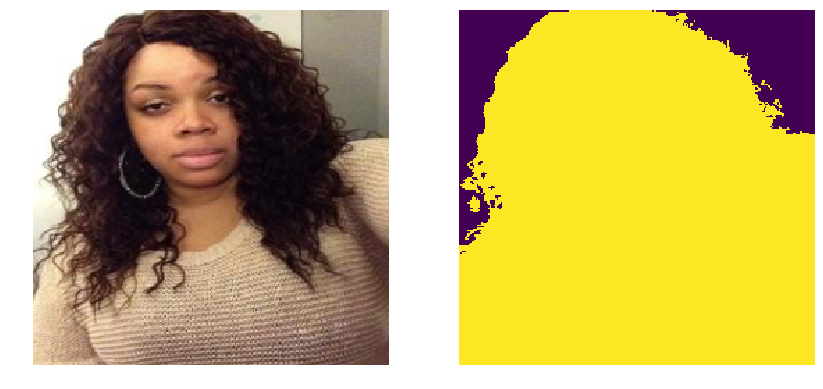

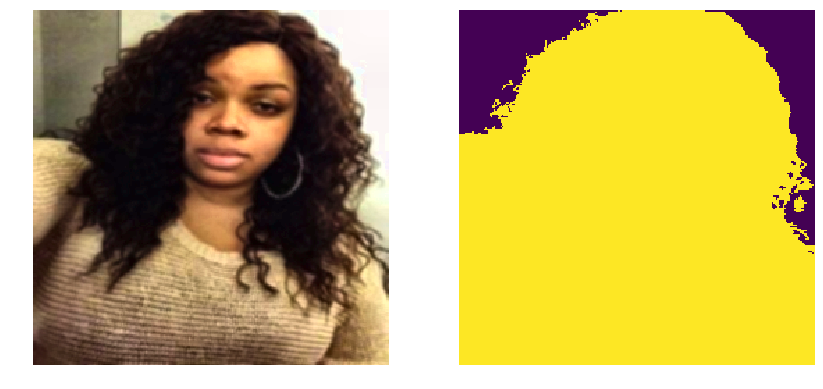

In [22]:
ind = random.randint(0,15) * 2

show_img_with_mask(x[ind], y[ind][..., 0])
show_img_with_mask(x[ind+1], y[ind+1][..., 0])

# Unet with mobilenet V2 backbone no data augmentation

Начнем с backbone mobilenet V2. Он легковесный из-за малого кол-ва параметров, поэтому итерации процесса обучения будут быстрее. Моя основная задача - пронаблюдать за процессом дообучения сети и понять, в каком направлении двигаться.

In [0]:
BACKBONE = 'mobilenetv2'
preprocess_input = sm.backbones.get_preprocessing(BACKBONE)

Обязательно заморозим веса энкодера, чтобы сеть не стала переучивать базовые признаки в картинке. Без этой опции часто видны яростные скачки на валидационном датасете. Также я видел информацию о том, что лучше будет замораживать веса энкодера на ранних этапах обучения, а далее размораживать их, используя стратегию learning_rate decay. К сожалению, не довелось попробовать ввиду недостатка времени.  
В качестве метрики используем dice coefficient.

In [250]:
# Определим модель
mob_u_no_augs = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)
mob_u_no_augs.compile(
    'Adam',
    loss=sm.losses.dice_loss,
    metrics=[sm.metrics.dice_score],
)

/usr/local/lib/python3.6/dist-packages/segmentation_models/backbones/mobilenetv2.py:274: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Также зададим коллбеки, для того чтобы сохранять последние и лучшие веса во время тренировки на каждой эпохе. Так мы сможем загрузить модель с более хорошими весами, если случайно её перетренировали или если что-то пошло не так.

In [0]:
best_w = keras.callbacks.ModelCheckpoint('mob_u_no_augs_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('mob_u_no_augs_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]

Рассмотрим поведение на 10 эпохах с размером батча 16

In [255]:
batch_size = 16
history_mob_u_no_augs = mob_u_no_augs.fit_generator(keras_generator(train_df, batch_size, train_path),
              steps_per_epoch=50,
              epochs=10,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size, val_path),
              validation_steps=50,
              class_weight=None,
              max_queue_size=1,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/10
50/50 [==============================] - 33s 667ms/step - loss: 0.0535 - iou_score: 0.9022 - val_loss: 0.0521 - val_iou_score: 0.9043
Epoch 2/10
50/50 [==============================] - 32s 638ms/step - loss: 0.0430 - iou_score: 0.9204 - val_loss: 0.0520 - val_iou_score: 0.9051
Epoch 3/10
50/50 [==============================] - 32s 642ms/step - loss: 0.0369 - iou_score: 0.9310 - val_loss: 0.0425 - val_iou_score: 0.9218
Epoch 4/10
50/50 [==============================] - 32s 640ms/step - loss: 0.0396 - iou_score: 0.9262 - val_loss: 0.0401 - val_iou_score: 0.9267
Epoch 5/10
50/50 [==============================] - 32s 639ms/step - loss: 0.0329 - iou_score: 0.9390 - val_loss: 0.0377 - val_iou_score: 0.9297
Epoch 6/10
50/50 [==============================] - 32s 640ms/step - loss: 0.0284 - iou_score: 0.9461 - val_loss: 0.0339 - val_iou_score: 0.9366
Epoch 7/10
50/50 [==============================] - 32s 635ms/step - loss: 0.0279 - iou_score: 0.9471 - val_loss: 0.0370 - val_iou

In [0]:
pred_mob_u_no_augs = mob_u_no_augs.predict(x_val)

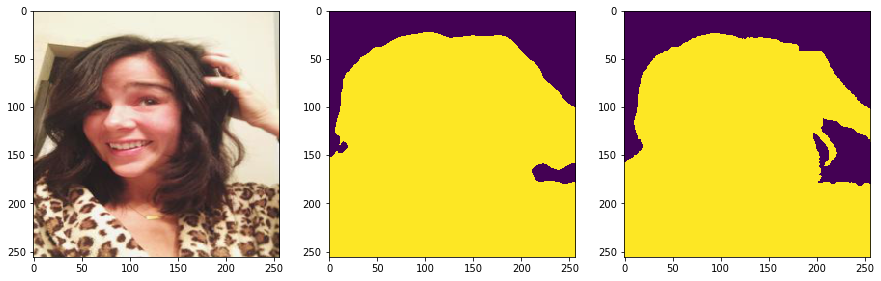

In [258]:
show_results(pred_mob_u_no_augs, x_val, y_val)

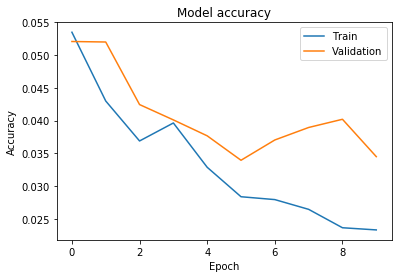

In [259]:
show_train_history(history_mob_u_no_augs)

Видим, что некоторые маски сеть выделяет приемлемо. В основном это картинки с:  
* Хорошо отделимым фоном
* Людьми в стандартных позициях  

Плохие маски получаются, если:  
* Человек стоит, сидит, лежит в нестандартной позиции
* Человек держит какой-либо объект

# Unet with mobilenet V2 backbone с аугментацией данных

Добавим аугментацию данных через Albumentations. Для этого был написан другой генератор, создающий аугментированные данные на ходу. После создания, они добавляются к текущему батчу. В связи с этим, размер батча увеличивается вдвое. Аугментации подбирались довольно продолжительное время. Было выяснено, что оптические искажения сказываются негативно на изображении, т.к. зачастую после их применения картинка смещается и её необходимо продолжить. При этом, если люди находятся близо к краю кадра, их части тела могут быть продолжены и даже продублированы. Т.к. данное это не свойственно датасету, такие аугментации мы не применяем.  
Вместо этого, были использованы более щадящие аугментации:
* HorizontalFlip
* Blur
* RandomContrast
* RandomGamma
* RandomBrightness
* HueSaturationValue
* CLAHE  

Польза аугментации данных в основном проявляется на поздних эпохах обучения. Она позволяет продолжить увеличение валидационного score на дополнительные ~0.5% после выхода на плато.


In [260]:
ob_u_with_augs, history_mob_u_with_augs = init_and_train_model(train_df, train_path, val_df, val_path, 'Unet', 'mobilenetv2', AUGMENTATIONS_TRAIN_LIGHT, 16, 10)

/usr/local/lib/python3.6/dist-packages/segmentation_models/backbones/mobilenetv2.py:274: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Epoch 1/10
50/50 [==============================] - 68s 1s/step - loss: 0.1570 - score: 0.8430 - val_loss: 0.0769 - val_score: 0.9231
Epoch 2/10
50/50 [==============================] - 51s 1s/step - loss: 0.0602 - score: 0.9398 - val_loss: 0.0592 - val_score: 0.9408
Epoch 3/10
50/50 [==============================] - 51s 1s/step - loss: 0.0437 - score: 0.9563 - val_loss: 0.0572 - val_score: 0.9428
Epoch 4/10
50/50 [==============================] - 51s 1s/step - loss: 0.0400 - score: 0.9600 - val_loss: 0.0428 - val_score: 0.9572
Epoch 5/10
50/50 [==============================] - 51s 1s/step - loss: 0.0342 - score: 0.9658 - val_loss: 0.0436 - val_score: 0.9564
Epoch 6/10
50/50 [==============================] - 51s 1s/step - loss: 0.0317 - score: 0.9683 - val_loss: 0.0399 - val_score: 0.9601
Epoch 7/10
50/50 [==============================] - 51s 1s/step - loss: 0.0311 - score: 0.9689 - val_loss: 0.0386 - val_score: 0.9614
Epoch 8/10
50/50 [==============================] - 51s 1s/ste

In [0]:
pred_mob_u = ob_u_with_augs.predict(x_val)

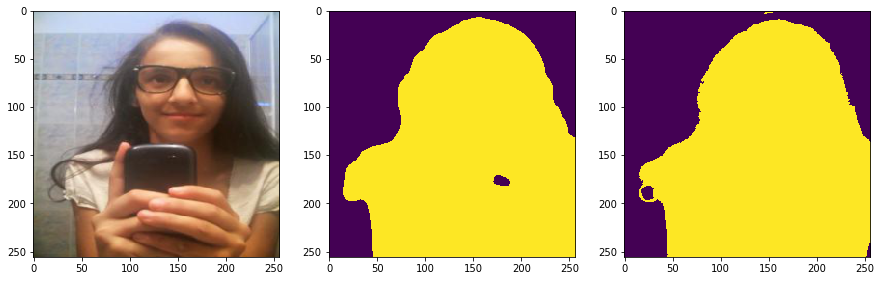

In [267]:
show_results(pred_mob_u, x_val, y_val)

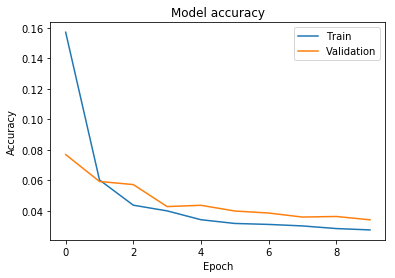

In [263]:
show_train_history(history_mob_u_with_augs)

# FPN with mobilenetv2 backbone

Попробуем использовать другую архитектуру сети с тем же backbone.

In [266]:
mob_fpn, history_mob_fpn = init_and_train_model(train_df, train_path, val_df, val_path, 'FPN', 'mobilenetv2', AUGMENTATIONS_TRAIN_LIGHT, 16, 30)

/usr/local/lib/python3.6/dist-packages/segmentation_models/backbones/mobilenetv2.py:274: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'



Epoch 1/30
50/50 [==============================] - 94s 2s/step - loss: 0.9133 - score: 0.0867 - val_loss: 0.9121 - val_score: 0.0879
Epoch 2/30
50/50 [==============================] - 65s 1s/step - loss: 0.9103 - score: 0.0897 - val_loss: 0.9103 - val_score: 0.0897
Epoch 3/30
50/50 [==============================] - 65s 1s/step - loss: 0.9102 - score: 0.0898 - val_loss: 0.9102 - val_score: 0.0898
Epoch 4/30
50/50 [==============================] - 65s 1s/step - loss: 0.9100 - score: 0.0900 - val_loss: 0.9101 - val_score: 0.0899
Epoch 5/30
50/50 [==============================] - 65s 1s/step - loss: 0.9100 - score: 0.0900 - val_loss: 0.9100 - val_score: 0.0900
Epoch 6/30
50/50 [==============================] - 65s 1s/step - loss: 0.9099 - score: 0.0901 - val_loss: 0.9100 - val_score: 0.0900
Epoch 7/30
50/50 [==============================] - 65s 1s/step - loss: 0.9099 - score: 0.0901 - val_loss: 0.9100 - val_score: 0.0900
Epoch 8/30
50/50 [==============================] - 64s 1s/st

In [0]:
pred_mob_fpn = mob_fpn.predict(x_val)

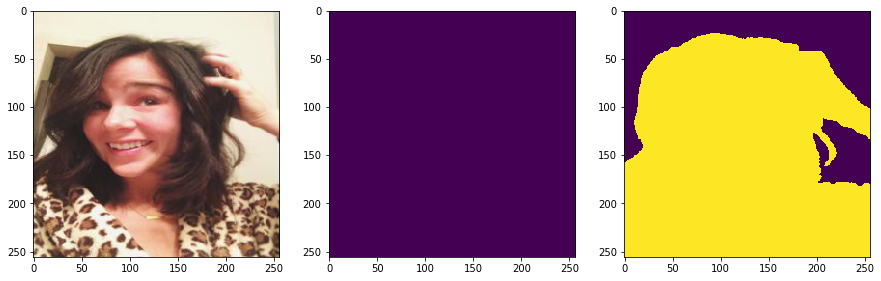

In [276]:
show_results(pred_mob_fpn, x_val, y_val)

К сожалению, повторилась ситуация с PSPNet. Полученные результат: Сети архитектуры PSPNet  и FPN не хотят учиться без дополнительной отладки и даже не могут провести сегментацию. Почти наверняка дело в моих кривых руках.

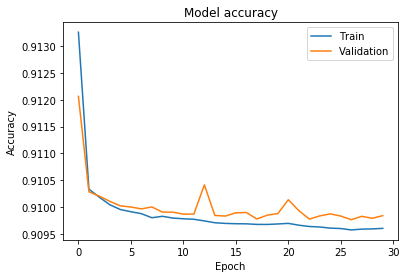

In [274]:
show_train_history(history_mob_fpn)

# Unet with resnet18 backbone

Остается использовать беспроигрышный вариант, который ранее сработал - опять учим Unet. В этот раз с другим backbone и учим основательно - в течение 30 эпох, до выхода на плато.

In [277]:
mob_fpn, history_mob_fpn = init_and_train_model(train_df, train_path, val_df, val_path, 'Unet', 'resnet18', AUGMENTATIONS_TRAIN_LIGHT, 16, 30)

44924928/44920640 [==============================] - 7s 0us/step
Epoch 1/30
50/50 [==============================] - 64s 1s/step - loss: 0.1474 - score: 0.8526 - val_loss: 0.0726 - val_score: 0.9274
Epoch 2/30
50/50 [==============================] - 45s 892ms/step - loss: 0.0595 - score: 0.9405 - val_loss: 0.0527 - val_score: 0.9473
Epoch 3/30
50/50 [==============================] - 44s 884ms/step - loss: 0.0473 - score: 0.9527 - val_loss: 0.0480 - val_score: 0.9520
Epoch 4/30
50/50 [==============================] - 44s 885ms/step - loss: 0.0394 - score: 0.9606 - val_loss: 0.0439 - val_score: 0.9561
Epoch 5/30
50/50 [==============================] - 44s 885ms/step - loss: 0.0342 - score: 0.9658 - val_loss: 0.0488 - val_score: 0.9512
Epoch 6/30
50/50 [==============================] - 44s 884ms/step - loss: 0.0320 - score: 0.9680 - val_loss: 0.0413 - val_score: 0.9587
Epoch 7/30
50/50 [==============================] - 45s 890ms/step - loss: 0.0298 - score: 0.9702 - val_loss: 0.0399

In [0]:
pred_mob_fpn = mob_fpn.predict(x_val)

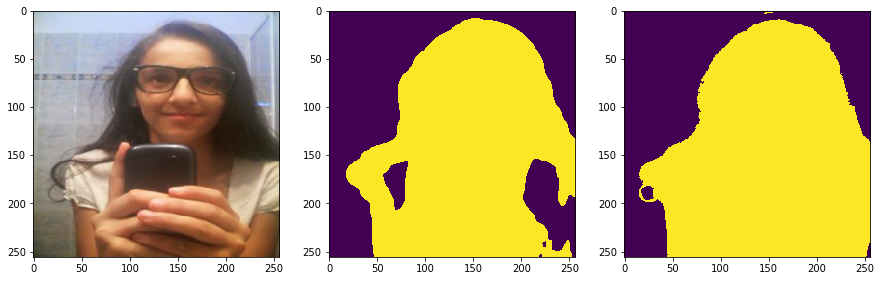

In [301]:
show_results(pred_mob_fpn, x_val, y_val)

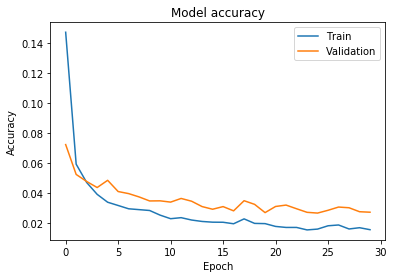

In [280]:
show_train_history(history_mob_fpn)

# Linknet with resnet34 backbone

Взамен неудавшихся попыток обучить архитектуры PSNet и FPN, попробуем обучить архитектуру Linknet с backbone resnet34.

In [281]:
link_34_model, history_link_34 = init_and_train_model(train_df, train_path, val_df, val_path, 'Linknet', 'resnet34', AUGMENTATIONS_TRAIN_LIGHT, 16, 30)

85524480/85521592 [==============================] - 1s 0us/step
Epoch 1/30
50/50 [==============================] - 68s 1s/step - loss: 0.2702 - score: 0.7298 - val_loss: 0.1061 - val_score: 0.8939
Epoch 2/30
50/50 [==============================] - 46s 918ms/step - loss: 0.0794 - score: 0.9206 - val_loss: 0.0620 - val_score: 0.9380
Epoch 3/30
50/50 [==============================] - 46s 925ms/step - loss: 0.0531 - score: 0.9469 - val_loss: 0.0491 - val_score: 0.9509
Epoch 4/30
50/50 [==============================] - 46s 919ms/step - loss: 0.0433 - score: 0.9567 - val_loss: 0.0463 - val_score: 0.9537
Epoch 5/30
50/50 [==============================] - 46s 913ms/step - loss: 0.0393 - score: 0.9607 - val_loss: 0.0552 - val_score: 0.9448
Epoch 6/30
50/50 [==============================] - 46s 918ms/step - loss: 0.0334 - score: 0.9666 - val_loss: 0.0501 - val_score: 0.9499
Epoch 7/30
50/50 [==============================] - 46s 917ms/step - loss: 0.0337 - score: 0.9663 - val_loss: 0.0501

In [0]:
pred_link_34 = link_34_model.predict(x_val)

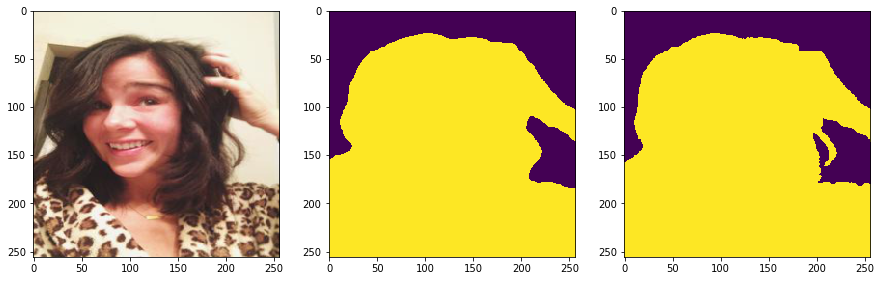

In [304]:
show_results(pred_link_34, x_val, y_val)

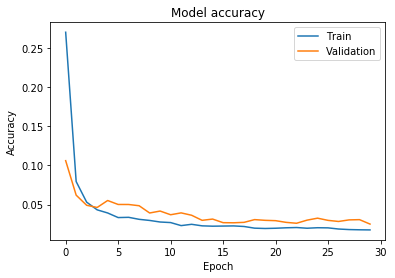

In [284]:
show_train_history(history_link_34)

# Заключение

По окончании работы получены следующие результаты:  
1. Лучшая из обученных сетей - Linknet с весами resnet34 Полученный dice score = 0.9750
2. Сеть плохо различает людей, находящихся в позициях нестандартных для датасета
3. Освоена работа с Segmentation models и написаны удобные функции для быстрого подбора архитектуры и backbone

Также намечен план дальнейших работ:
* Необходимо разобраться, почему не удается обучить сети с архитектурами FPN и PSPNet. Возможно проблема кроется в заморозке весов энкодера.
* Стоит провести детальное исследование влияния аугментаций на обучение. Стоит обучить одну сеть в одинаковых условях с различными аугментациями и по метрикам выбрать те, которые помогают при обучении.
* Создать архитектуру Unet с нуля и обучить без предобучения. Если аугментировать датасет, его вполне может хватить для получения приемлемого качества.
* Провести fine tuning оптимизатора, используя градиентный спуск с momentum и weght decay. Adam быстро сходится и дает приемлемое качество, но точно можно добится лучшего с различными модификациями SGD.

# Запись результатов

Выбираем веса лучшей модели и загружаем их:

In [0]:
end_model = sm.Linknet("resnet34",input_shape = (256, 256, 3), encoder_weights='imagenet', encoder_freeze=True)
end_model.load_weights('Linknet_resnet34_best.h5')

In [0]:
x_test = [cv2.resize(np.array(Image.open(path)), (256, 256)) for path in sorted(test_files)]
  
paths_to_imgs = sorted(test_files)
pred_masks = end_model.predict(np.array(x_test))

In [0]:
val_df = pd.DataFrame(columns = ['img' , 'mask_rle'])
for e in valid_files:
    index = e.split("/")[2].split('.')[0]
    val_df.loc[index] = ['/content/' + e, encode_rle(np.array(Image.open(f"{val_path}_mask/{index}.png")))]

In [0]:
res_df = predict_Valid(end_model, val_df)

In [321]:
res_df.to_csv('pred_valid.csv')
res_df.head()

,id,mask_rle
0,1431,64 123 303 124 542 126 779 130 1016 134 1253 1...
1,1352,8974 2 9211 6 9450 12 9468 6 9689 27 9725 5 97...
2,1437,8737 3 8759 3 8976 28 9215 31 9455 34 9695 39 ...
3,1377,1855 8 2093 11 2332 13 2571 15 2806 20 3044 23...
4,1406,22174 9 22413 11 22651 14 22888 18 23115 8 231...


In [0]:
res_masks = predict_Test(end_model)

In [0]:
paths_to_imgs = sorted(glob("data/test/*"))

_ = get_html(paths_to_imgs, res_masks, path_to_save="results/final")

In [0]:
!zip -rq /content/final.zip /content/results/final